# Time Series: Exchange Rate Forecasting

Given a dataset containing the data from Quandyl. The data describes the bank of England's official stats on spot exchange rates for the Pounds into US dollars.

**TASK:** Analyse the future rates.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

from io import StringIO
import time
import json

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = (15, 6)

In [3]:
df = pd.read_csv('data/BOE-XUDLERD.csv')
df.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


In [4]:
df.shape

(10837, 2)

In [5]:
# Date is in object - Need to convert to datetime format
df.dtypes

Date      object
Value    float64
dtype: object

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.dtypes

Date     datetime64[ns]
Value           float64
dtype: object

In [8]:
# Set index to Date
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2017-11-09,0.8603
2017-11-08,0.8631
2017-11-07,0.8639
2017-11-06,0.8631
2017-11-03,0.8608


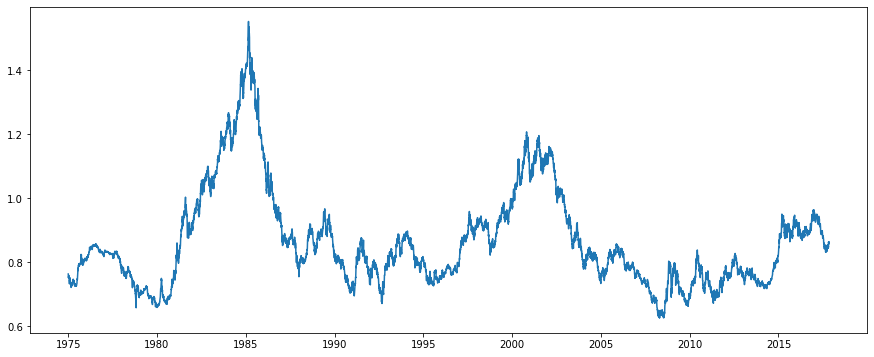

In [9]:
plt.plot(df)
plt.show()

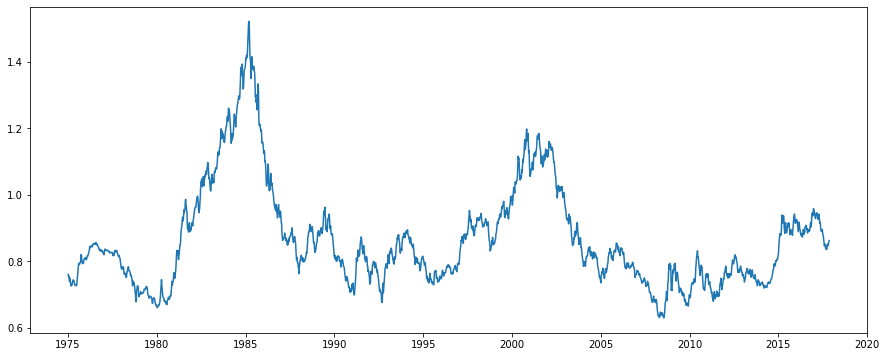

In [10]:
# Convert into Week basis
ts_week = df.resample('W').mean()

plt.plot(ts_week)
plt.show()

In [11]:
ts_week.head()

,Value
Date,
1975-01-05,0.76090
1975-01-12,0.75346
1975-01-19,0.75546
1975-01-26,0.74388
1975-02-02,0.73902


### Test Stationarity in TS (Dickey Fuller Test)

In [12]:
def test_stationarity(ts):
    # Determine stationarity using rolling Stats
    roll_mean = ts.rolling(window=52).mean()
    roll_std = ts.rolling(window=52).std()
    
    plt.plot(ts, color='blue', label='Original ts')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Std')
    plt.show()
    
    # Perform Dickey Fuller Test
    print("\nResults of Dickey Fuller Test: \n")
    df_test = adfuller(ts)
    df_output = pd.Series(df_test[:4], index=['Test Statistics', 'P-value', '#Lags Used', '#Observations'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

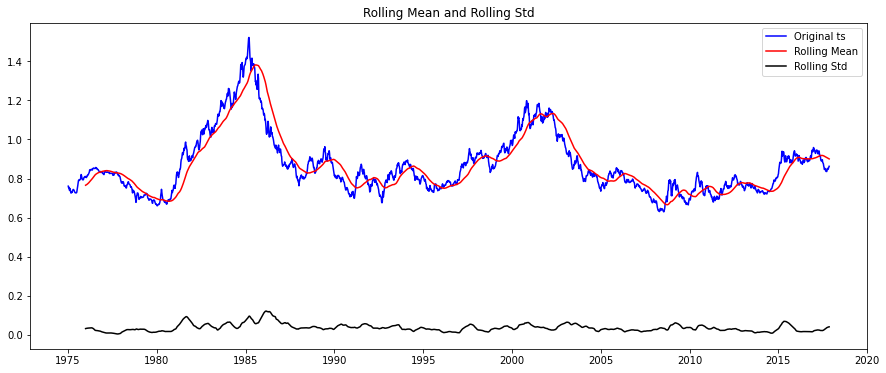


Results of Dickey Fuller Test: 

Test Statistics           -2.076341
P-value                    0.254134
#Lags Used                 2.000000
#Observations           2234.000000
Critical Value (1%)       -3.433281
Critical Value (5%)       -2.862835
Critical Value (10%)      -2.567459
dtype: float64


In [13]:
test_stationarity(ts_week)

**NOTE:** As by rolling mean test, the mean is not constant over the years, std is also fluctuating a bit, so no stationarity in TS.

In Dickey Fuller test, it can be clearly seen that the p-value is greater than 0.05, so we fail to reject Null Hypothesis, Hence this TS is not stationary.

We can take a difference or shift of 1 and we will check again if the TS is stationary or not.
First we will convert it into log scale.

In [14]:
ts_week_log = np.log(ts_week)

ts_week_log.head()

,Value
Date,
1975-01-05,-0.273253
1975-01-12,-0.283079
1975-01-19,-0.280428
1975-01-26,-0.295876
1975-02-02,-0.302430


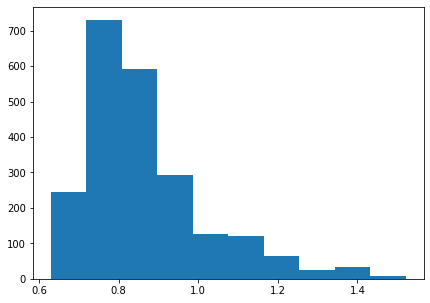

In [15]:
# Skewed Data - Convert to log Scale
plt.figure(figsize=(7, 5))
plt.hist(ts_week)
plt.show()

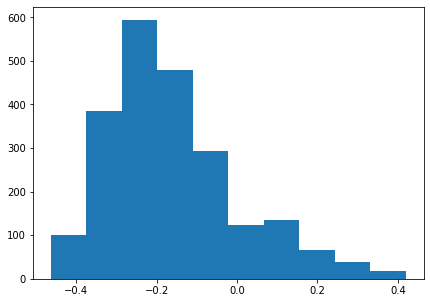

In [16]:
# Better than before
plt.figure(figsize=(7, 5))
plt.hist(ts_week_log)
plt.show()

In [17]:
ts_week_log_diff = ts_week_log - ts_week_log.shift()

ts_week_log_diff.head()

,Value
Date,
1975-01-05,NaN
1975-01-12,-0.009826
1975-01-19,0.002651
1975-01-26,-0.015447
1975-02-02,-0.006555


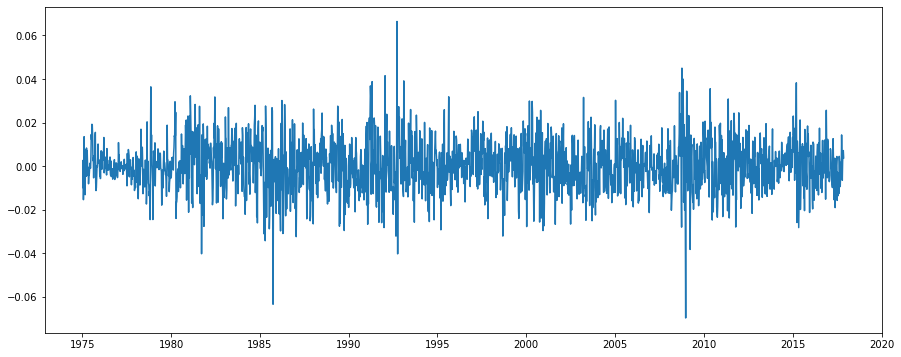

In [18]:
plt.plot(ts_week_log_diff)
plt.show()

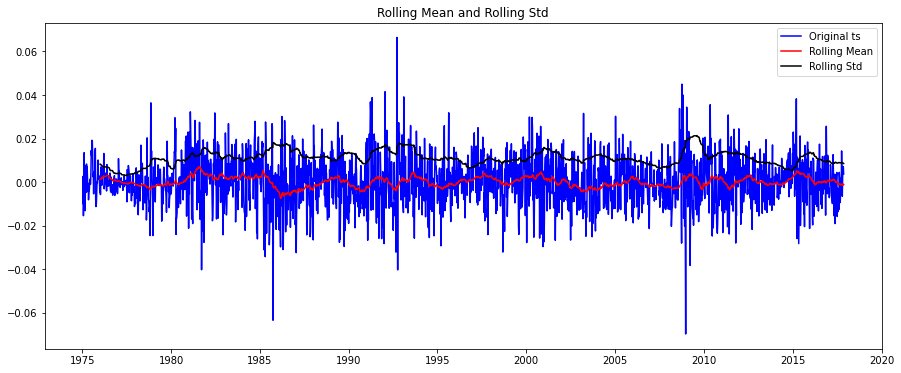


Results of Dickey Fuller Test: 

Test Statistics          -36.590004
P-value                    0.000000
#Lags Used                 0.000000
#Observations           2235.000000
Critical Value (1%)       -3.433279
Critical Value (5%)       -2.862834
Critical Value (10%)      -2.567459
dtype: float64


In [19]:
ts_week_log_diff.dropna(inplace=True)

test_stationarity(ts_week_log_diff)

**NOTE:** As by rolling mean test, the mean constant over the years, std is also constant, TS is stationary.

In Dickey Fuller test, it can be clearly seen that the p-value is less than 0.05, so we reject the Null Hypothesis, Hence this TS is stationary.

`We get the value of d which is 1 becoz by taking shift of 1, our data become stationary.`

Now we are heading towards finding the value of p and q

In [20]:
# ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=20)
lag_pacf = pacf(ts_week_log_diff, nlags=20)

In [21]:
lag_acf

array([ 1.        ,  0.25046862,  0.03934399,  0.02220274,  0.02007253,
        0.00431513, -0.01417335, -0.00714647,  0.02560459,  0.00680146,
        0.00221343,  0.0332745 ,  0.01471063,  0.01692689,  0.02797282,
        0.02230493, -0.00836548,  0.00846803, -0.00586896,  0.00557443,
        0.01010628])

In [22]:
lag_pacf

array([ 1.00000000e+00,  2.50580682e-01, -2.49799755e-02,  1.96214210e-02,
        1.13779743e-02, -3.94587427e-03, -1.55918231e-02, -9.32949186e-05,
        2.93234251e-02, -6.95929218e-03,  2.65667718e-03,  3.40913301e-02,
       -3.31937037e-03,  1.43865495e-02,  2.18955296e-02,  9.80869496e-03,
       -1.93842562e-02,  1.64443866e-02, -1.30253880e-02,  9.04343491e-03,
        8.01817578e-03])

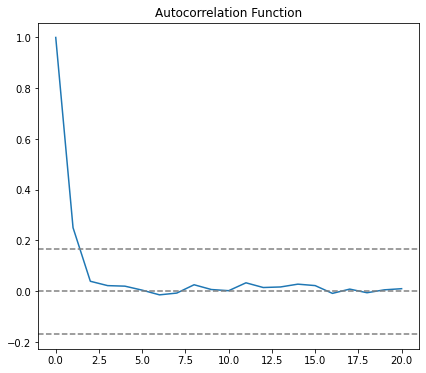

In [23]:
rcParams['figure.figsize'] = (15, 6)
plt.subplot(121)
plt.plot(lag_acf)

plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

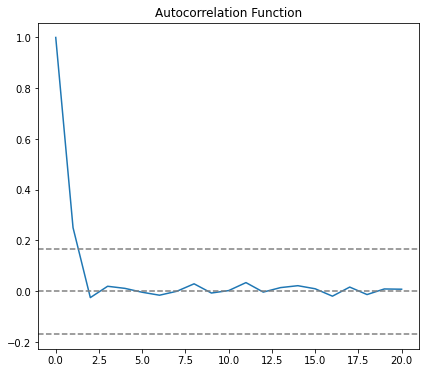

In [24]:
rcParams['figure.figsize'] = (15, 6)

plt.subplot(122)
plt.plot(lag_pacf)

plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

**NOTE:** Lag is becoming 0 @ 2 for the first time, that means we got our value of p i.e. 2 from pacf.

Lag crossing first threshold limit @ 1, so q = 1 from acf

We got our ARIMA model for our time series of order ARIMA(2, 1, 1)

### Modeling ARIMA(2, 1, 1)

In [25]:
model = ARIMA(ts_week_log, order=(2, 1, 1))
res_ARIMA = model.fit(disp=-1)

In [26]:
len(res_ARIMA.fittedvalues), len(ts_week_log)

(2236, 2237)

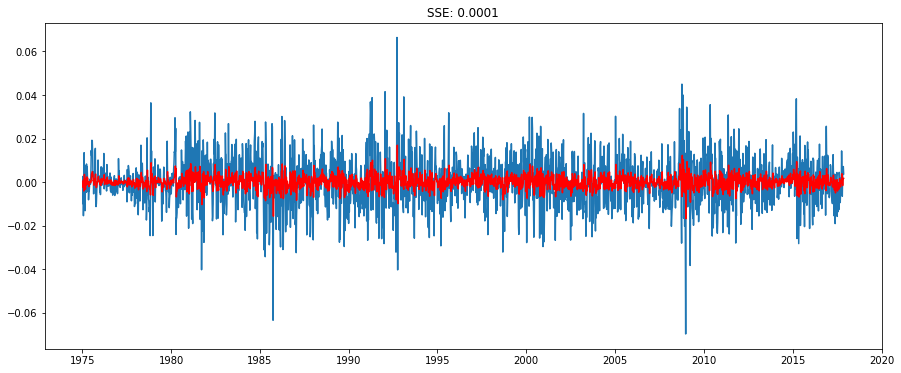

In [27]:
plt.plot(ts_week_log_diff)
plt.plot(res_ARIMA.fittedvalues, color='red')
plt.title(f"SSE: {mean_squared_error(ts_week_log_diff, res_ARIMA.fittedvalues):.4f}")
plt.show()

In [28]:
res_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 04 May 2021   AIC                         -13731.202
Time:                        18:00:57   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128      0.469      0.639      -0.191       0.312
ma.L1.D.Value     0.3475      0.485      0.716      0.474      -0.604       1.299
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3960           +0.0000j            3.3960            0.5000
AR.2            4.8929           +0.0000j            4.8929            0.0000
MA.1           -2.8774           +0.0000j            2.8774            0.5000
-----------------------------------------------------------------------------
"""

**NOTE:** Equation of time series: **`y = mu + beta0*AR.1 + beta1*AR.2 + beta2*MA.1`**

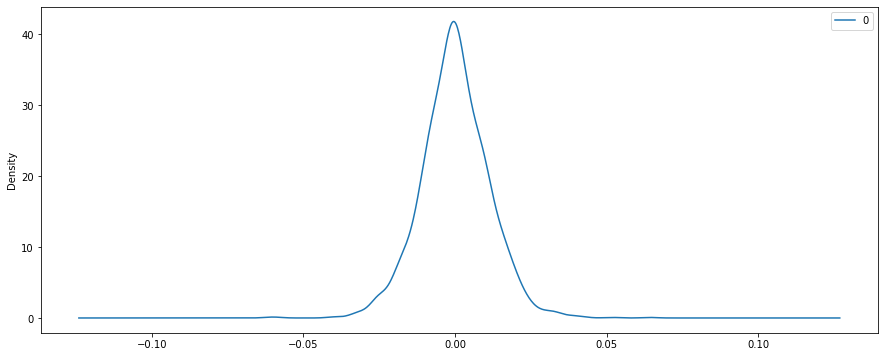

                 0
count  2236.000000
mean      0.000001
std       0.011205
min      -0.061306
25%      -0.006725
50%      -0.000228
75%       0.006869
max       0.064140


In [29]:
# Plot residual errors
resid = pd.DataFrame(res_ARIMA.resid)
resid.plot(kind='kde')
plt.show()
print(resid.describe())

**NOTE:** Residuals are white noise clearly.

In [30]:
res_ARIMA.forecast(2)

(array([-0.14695356, -0.14674697]),
 array([0.01120189, 0.01799704]),
 array([[-0.16890886, -0.12499826],
        [-0.18202053, -0.11147342]]))

**NOTE:** Values in first cell is the forecast of next two days

Second cell contains the standard error associated with it.

Third cell contains the confidence interval for both forecast.

In [34]:
predictions_ARIMA_diff = pd.Series(res_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


In [51]:
ts_week_log.index

DatetimeIndex(['1975-01-05', '1975-01-12', '1975-01-19', '1975-01-26',
               '1975-02-02', '1975-02-09', '1975-02-16', '1975-02-23',
               '1975-03-02', '1975-03-09',
               ...
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12'],
              dtype='datetime64[ns]', name='Date', length=2237, freq='W-SUN')

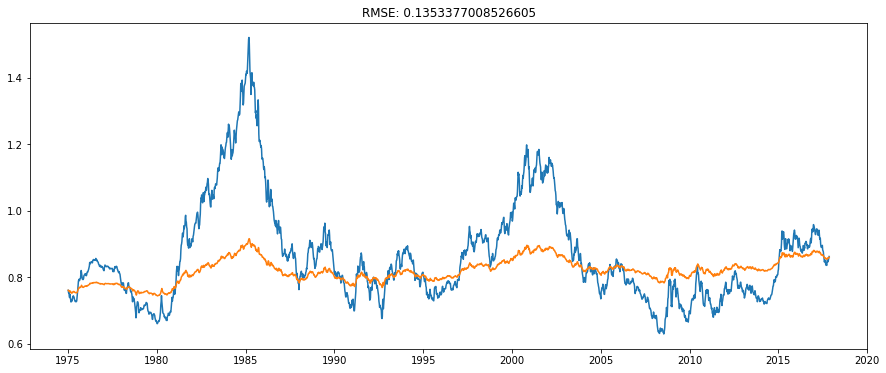

In [74]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0].Value, index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title(f'RMSE: {np.sqrt(mean_squared_error(predictions_ARIMA, ts_week))}')
plt.show()

In [75]:
predictions_ARIMA

Date
1975-01-05    0.760900
1975-01-12    0.760942
1975-01-19    0.759103
1975-01-26    0.759853
1975-02-02    0.756741
                ...   
2017-10-15    0.858464
2017-10-22    0.857076
2017-10-29    0.857713
2017-11-05    0.859016
2017-11-12    0.860509
Freq: W-SUN, Length: 2237, dtype: float64

In [63]:
ts_week_log.iloc[0].Value

-0.2732533357996601

In [67]:
ts_week_log.ix[0]

Value   -0.273253
Name: 1975-01-05 00:00:00, dtype: float64

### Train-Test Split

In [87]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log.Value[:size], ts_week_log.Value[size:]
history = [x for x in train]

history

[-0.2732533357996601,
 -0.2830793479252081,
 -0.2804284437404728,
 -0.29587554748030875,
 -0.3024302948006891,
 -0.2889361918642178,
 -0.299188012637983,
 -0.3073679065685495,
 -0.32050834038333104,
 -0.3192690634115926,
 -0.3118108440303757,
 -0.3165206008195087,
 -0.3082249736831103,
 -0.30425193078094587,
 -0.2971130715143842,
 -0.29533797086269636,
 -0.29967368530415894,
 -0.30026760573628175,
 -0.30840192026612107,
 -0.3130409069186711,
 -0.3172619415818973,
 -0.3190007557092083,
 -0.31770151410470376,
 -0.31833373831795864,
 -0.3192965862211228,
 -0.314957350586864,
 -0.3004296452742835,
 -0.28837564625182527,
 -0.2691874898156165,
 -0.2502064708638989,
 -0.2364567803763352,
 -0.23395175003081314,
 -0.23029405534305067,
 -0.2356970173858298,
 -0.23092373863317212,
 -0.22888500194332376,
 -0.22667477876552747,
 -0.2132674806440034,
 -0.19779261887854052,
 -0.20545099178329168,
 -0.21671426354930587,
 -0.22664969064349752,
 -0.2311505217161261,
 -0.23112532105586744,
 -0.2314025632

In [88]:
ts_week_log.shape

(2237, 1)

In [89]:
train.shape

(2222,)

In [90]:
test.shape

(15,)

In [91]:
pred = list()

print("Predicted VS Expected Values...\n")

for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(float(yhat))
    obs = test[t]
    history.append(obs)
print(f"Predicted = {np.exp(yhat)[0]} | Expected = {np.exp(obs)}")    

Predicted VS Expected Values...

Predicted = 0.8608527265508911 | Expected = 0.8625999999999999


In [93]:
error = mean_squared_error(test, pred)
print(f"Test Mean Squared Error for Predictions..\n")
print(f"{error:.6f}")

Test Mean Squared Error for Predictions..

0.000043


In [94]:
prediction_series = pd.Series(pred, index = test.index)

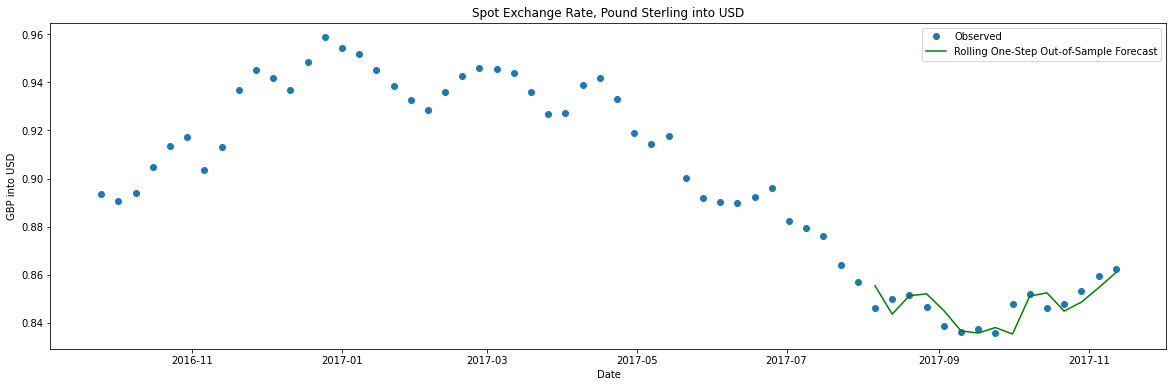

In [95]:
rcParams['figure.figsize'] = (20,6)
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Pound Sterling into USD', xlabel='Date', ylabel='GBP into USD')
ax.plot(ts_week[-60:], 'o', label='Observed')
ax.plot(np.exp(prediction_series), 'g', label='Rolling One-Step Out-of-Sample Forecast')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')
plt.show()